## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2020.

# ECBM E4040 - Assignment 2- Task 5: Kaggle Open-ended Competition

Kaggle is a platform for predictive modelling and analytics competitions in which companies and researchers post data and statisticians and data miners compete to produce the best models for predicting and describing the data.

If you don't have a Kaggle account, feel free to join at [www.kaggle.com](https://www.kaggle.com). To let the CAs do the grading more conveniently, please __use Lionmail to join Kaggle__ and __use UNI as your username__.

The website for this competition is: https://www.kaggle.com/c/ecbm-e4040fall2020-assignment-2-task-5.

You can find detailed description about this in-class competition on the website above. Please read carefully and follow the instructions.

<span style="color:red">__TODO__:</span>
1. Train a custom model for the bottle dataset classification problem. You are free to use any methods taught in the class or found by yourself on the Internet (ALWAYS provide reference to the source).
General training methods include:
    * Dropout
    * Batch normalization
    * Early stopping
    * l1-norm & l2-norm penalization
2. You'll be given the test set to generate your predictions (70% public + 30% private, but you don't know which ones are public/private). Achieve 70% accuracy on the public test set. The accuracy will be shown on the public leaderboard once you submit your prediction .csv file. The private leaderboard would be released after the competition. The final ranking would based on that result, not the public one.
3. 

    * Report your results on the Kaggle, for comparison with other students' optimal results (you can do this several times). 
    * Save your best model, using Github Classroom, at the same time when you submit the homework files into Courseworks. See instructions below. 

__Hint__: You can start from what you implemented in task 4. Another classic classification model named 'VGG16' can also be easily implemented. Students are allowed to use pretrained networks, and utilize transfer learning. 

## HW Submission Details:
There are three components to reporting the results of this task: 

**(A) Submission (up to 20 submissions each day) of the .csv prediction file throught the Kaggle platform;**. You should start doing this __VERY early__, so that students can compare their work as they are making progress with model optimization.

**(B) Editing and submitting the content of this Jupyter notebook, through Courseworks; **
(i) The code for your CNN model and for the training function. The code should be stored in __./ecbm4040/neuralnets/kaggle.py__;
(ii) Print out your training process and accuracy __within this notebook__;

**(C) Submitting your best CNN model through Github Classroom repo.**

**Description of (C):** 
For this task, we will continue to use Github classroom to save your model for submission. 

<span style="color:red">__Submission content:__ :</span>
(i) In your Assignment 2 submission folder, create a subfolder called __KaggleModel__. Upload your best model with all the data output (for example, __MODEL.data-00000-of-00001, MODEL.meta, MODEL.index__) into the folder. 
(ii) Remember to delete any intermediate results, **we only want your best model. Do not upload any data files**. The instructors will rerun the uploaded best model and verify against the score which you reported on the Kaggle.



## Load Data

In [1]:
# YOUR CODE HERE
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import modules
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img

# create generator and data augmentation
datagen = ImageDataGenerator(validation_split=0.2, 
                             horizontal_flip=True,
                             width_shift_range=[-20,20],
                             rescale=1./255,
                             rotation_range=40)

# datagen = ImageDataGenerator(validation_split=0.2)

# prepare an iterators for each dataset
directory_train = 'data/kaggle-fall2020/kaggle_train_128/train_128/'
directory_test = 'data/kaggle-fall2020/kaggle_test_128/'

# train set
train_bottle = datagen.flow_from_directory(
    directory=directory_train, 
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset='training')

# validation set
validation_bottle = datagen.flow_from_directory(
    directory=directory_train,  # same directory as training data
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

# test set
test_bottle = datagen.flow_from_directory(
    directory=directory_test,
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42)

# confirm the iterator works
batchX, batchy = train_bottle.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 12000 images belonging to 5 classes.
Found 3000 images belonging to 5 classes.
Found 3500 images belonging to 1 classes.
Batch shape=(32, 128, 128, 3), min=0.000, max=1.000


## Build and Train Your Model Here

In [4]:
# YOUR CODE HERE
import pandas as pd
import os
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from utils.cifar_utils import load_data

In [5]:
STEP_SIZE_TRAIN = train_bottle.n // train_bottle.batch_size
STEP_SIZE_VALID = validation_bottle.n // validation_bottle.batch_size
print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)

375 93


In [6]:
# Transfer learning: we will use VGG model
from tensorflow.keras.applications import VGG19, VGG16

In [7]:
# import the VGG model
base_model=VGG19(weights='imagenet',include_top=False) 

from tensorflow.keras.layers import Dropout, BatchNormalization
# from Part 4 of Task 4
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu', name='Dense1')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.5)(x)
x=Dense(1024,activation='relu', name='Dense2')(x) #dense layer 2
x=Dropout(0.5)(x)
x=Dense(512,activation='relu', name='Dense3')(x) #dense layer 3
preds=Dense(5,activation='softmax')(x) #final layer with softmax activation

In [8]:
model=Model(inputs=base_model.input,outputs=preds,name='Kaggle_model')

In [9]:
from tensorflow.keras.models import Sequential
# loop through layers, add Dropout after layers 'fc1' and 'fc2'
updated_model = Sequential()
i = 1
for layer in model.layers:
    updated_model.add(layer)
    if layer.name in ['block1_conv2', 'block2_conv2', 'block3_conv4', 'block4_conv4', 'block5_conv4']:
        updated_model.add(BatchNormalization(name='bn_{}'.format(i)))
        i += 1

model = updated_model

In [10]:
for layer in model.layers[:11]:
    layer.trainable=False
for layer in model.layers[11:]:
    layer.trainable=True

In [11]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, None, None, 64)    256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
bn_2 (BatchNormalization)    (None, None, None, 128)   5

In [12]:
epc = 25 #number of epoches

# train the model
history = model.fit_generator(generator=train_bottle,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_bottle,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
375/375 [==============================] - 106s 282ms/step - loss: 1.3755 - accuracy: 0.4161 - val_loss: 1.1727 - val_accuracy: 0.5420
Epoch 2/25
375/375 [==============================] - 105s 279ms/step - loss: 0.7572 - accuracy: 0.7541 - val_loss: 0.6981 - val_accuracy: 0.7681
Epoch 3/25
375/375 [==============================] - 104s 278ms/step - loss: 0.5435 - accuracy: 0.8257 - val_loss: 0.4278 - val_accuracy: 0.8522
Epoch 4/25
375/375 [==============================] - 104s 278ms/step - loss: 0.4696 - accuracy: 0.8522 - val_loss: 0.3778 - val_accuracy: 0.8915
Epoch 5/25
375/375 [==============================] - 104s 278ms/step - loss: 0.3994 - accuracy: 0.8751 - val_loss: 0.4168 - val_accuracy: 0.8713
Epoch 6/25
375/375 [==============================] - 104s 278ms/step - loss: 0.3531 - accuracy: 0.8908 - val_loss: 0.2716 - val_accuracy: 0.9177
Epoch 7/25
375/375 [============================

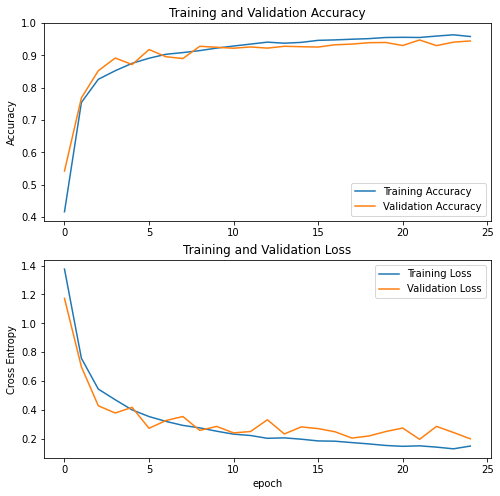

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
# evaludate the model
model.evaluate_generator(generator=validation_bottle,
steps=STEP_SIZE_VALID)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.20820246636867523, 0.9378360509872437]

In [ ]:
# predict the output
STEP_SIZE_TEST=test_bottle.n//test_bottle.batch_size
test_bottle.reset()
pred=model.predict_generator(test_bottle,
steps=STEP_SIZE_TEST,
verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
 267/3500 [=>............................] - ETA: 49s

In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

In [ ]:
labels = (train_bottle.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

## Save your best model

In [ ]:
# YOUR CODE HERE
model.save('KaggleModel/KaggleModel.h5')

## Generate .csv file for Kaggle

In [ ]:
# The following code snippet can be used to generate your prediction .csv file.

# import csv
# with open('predicted.csv','w') as csvfile:
#     fieldnames = ['Id','label']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()
#     for index,l in enumerate(predicted_values_generated_by_your_model):
#         filename = '{:05d}'.format(index)+'.png'
#         label = str(l)
#         writer.writerow({'Id': filename, 'label': label})

filenames=[x.lstrip('test_128/') for x in test_bottle.filenames]
results=pd.DataFrame({"Id":filenames,
                      "label":predictions})
results.to_csv("prediction_label.csv",index=False)

# <span style="color:red">PLEASE CHECK THIS BOX</span> #

Since I used VGG-19 as a pre-trained model which is too large, I cannot push it onto Github, I will attach a link below. If you have any question about the link, please let me know! Thank You!

https://drive.google.com/drive/folders/1N80VTPrCLI6LGjQlgBfJHxCmIpE3fzUo?usp=sharing